In [1]:
import torch 
import torch.nn as nn

from skimage import io
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
im_path = "/kaggle/input/image-net-visualization/bird_1.png"
model_path = "vit_tiny_patch16_224.augreg_in21k"
image_size = 1024

In [3]:
def get_image(im_path,shape=image_size):
    img = io.imread(im_path)[:,:,:3]
    org_img = img.copy()
    img = A.Normalize()(image=img)["image"]
    norm_img = img.copy()
    img = np.transpose(img,(2,0,1))
    img = np.expand_dims(img,0)

    img = torch.tensor(img)
    img = nn.Upsample((shape,shape))(img)
    
    return img,norm_img, org_img

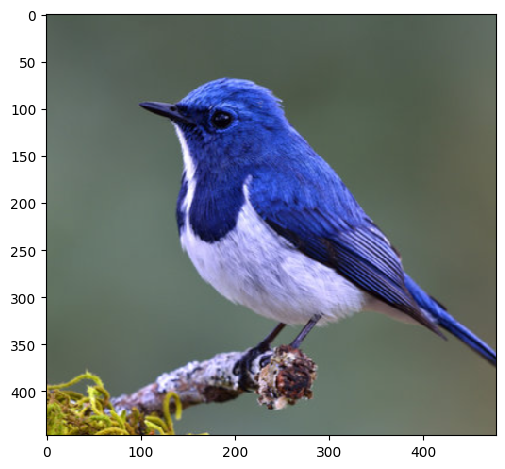

In [4]:
img,norm_img, org_img = get_image(im_path)
io.imshow(org_img)

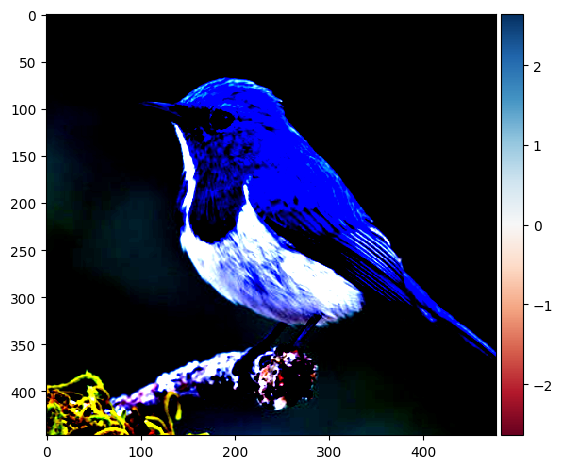

In [5]:
io.imshow(norm_img)

In [6]:
%%capture
! pip install timm

In [145]:
import timm
model = timm.create_model(model_path,img_size=image_size, dynamic_img_size=True,pretrained=True).cuda()

In [149]:
outputs = {}
def get_outputs(name):
    def hook(model, input, output):
            outputs[name] = output.detach()
        
    return hook

In [150]:
model.cuda().blocks[-1].attn.q_norm.register_forward_hook(get_outputs('q'))
model.cuda().blocks[-1].attn.k_norm.register_forward_hook(get_outputs('k'))
# model.cuda().blocks[-1].attn.qkv.register_forward_hook(get_outputs('qkv',model.cuda().blocks[-1].attn))

model.cuda().blocks[-1].register_forward_hook(get_outputs('last_layer'))
model.cuda()(img.cuda())

tensor([[-17.8622, -10.2267, -20.4025,  ..., -18.6733, -14.7363, -11.5430]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [151]:
outputs["attentions"] = outputs["q"] @ outputs["k"].transpose(-2, -1)

In [154]:
outputs["attentions"].shape ## B, num_heads, num_patches+1,num_patches+1

torch.Size([1, 3, 4097, 4097])

In [155]:
print(
"\n last_hidden_state",outputs["last_layer"].shape, 
"\n attentions last layer", outputs["attentions"].shape, 
)


 last_hidden_state torch.Size([1, 4097, 192]) 
 attentions last layer torch.Size([1, 3, 4097, 4097])


In [156]:
map_size = int(np.sqrt(4096))

## Visualizing Feature Vector Outputs patchwise based on mean

In [157]:
feature =  outputs["last_layer"] ## 1xnum_patches+1x768

In [158]:
feature_map = feature.mean(axis=-1) ## taking mean at feature axis ## [num_patches+1x]
feature_map = feature_map[:,1:] ## removing cls token ## [1,num_patches]


feature_map = feature_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

feature_map = nn.Upsample(size=(image_size,image_size))(feature_map)
print(feature_map.shape)

torch.Size([1, 1, 1024, 1024])


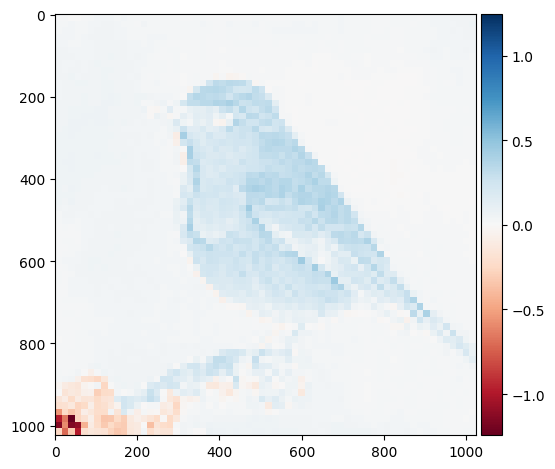

In [159]:
feature_map = feature_map[0,0,:,:].detach().cpu().numpy()

# feature_map = (feature_map-feature_map.min())/(feature_map.max()-feature_map.min())
io.imshow(feature_map)

## Visualizing Attentions Vector Outputs patchwise based on mean

In [160]:
attentions = outputs["attentions"] ## 1xnum_heads,num_patches+1x768
print(attentions.shape)

torch.Size([1, 3, 4097, 4097])


torch.Size([1, 1, 1024, 1024])


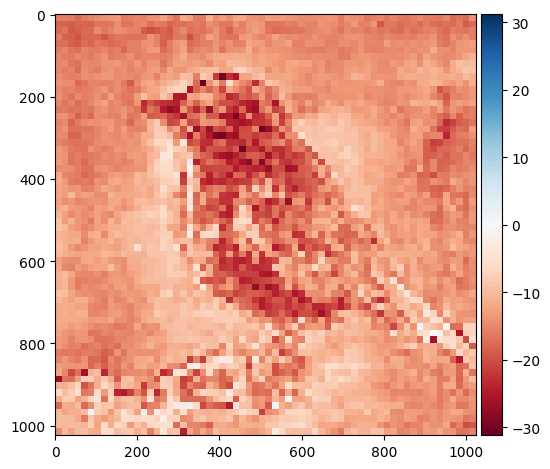

torch.Size([1, 1, 1024, 1024])


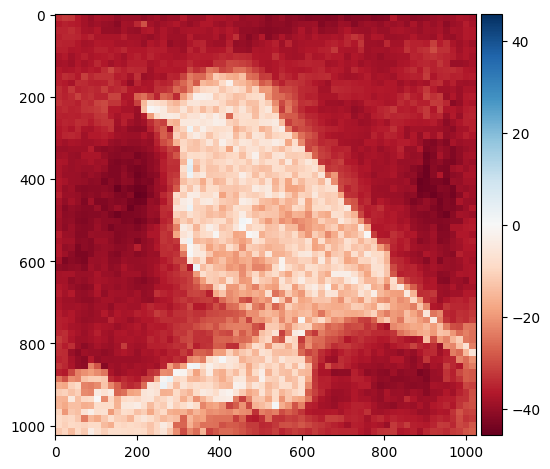

torch.Size([1, 1, 1024, 1024])


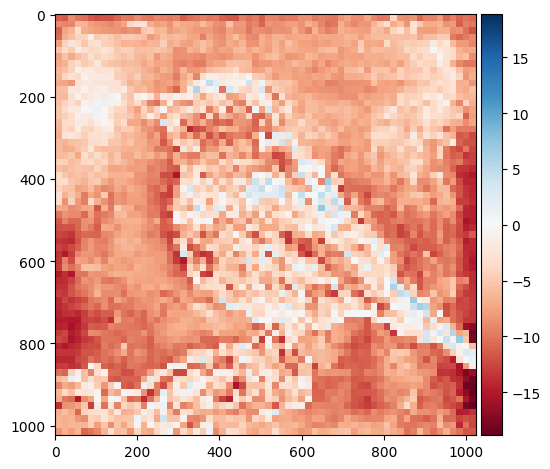

In [161]:
num_heads = attentions.shape[1]

for attention_head in range(num_heads):
    attentions_map = attentions[:,attention_head,:,0]
    attentions_map = attentions_map[:,1:] ## removing cls token ## [1,num_patches]
#     map_size = int(np.sqrt(4096))

    attentions_map = attentions_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

    attentions_map = nn.Upsample(size=(image_size,image_size))(attentions_map)
    print(attentions_map.shape)

    attentions_map = attentions_map[0,0,:,:].detach().cpu().numpy()

#     attentions_map = (attentions_map-attentions_map.min())/(attentions_map.max()-attentions_map.min())
    io.imshow(attentions_map)
    plt.show()
    

## Visualizing Attentions Vector Outputs patchwise based on mean of all heads

In [165]:
attentions = outputs["attentions"] ## 1xnum_patches+1x768
print(attentions.shape)

torch.Size([1, 3, 4097, 4097])


torch.Size([1, 1, 1024, 1024])


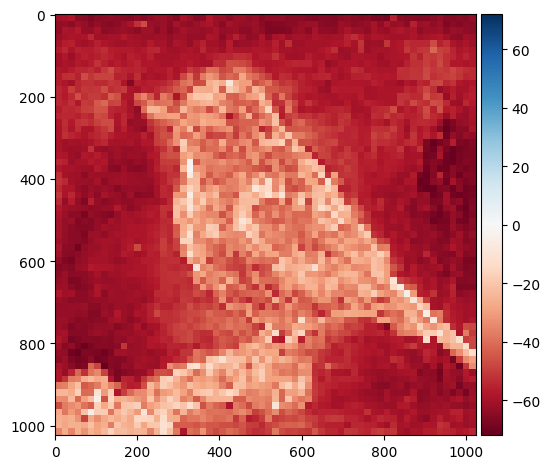

In [166]:
attentions_map = attentions.sum(axis=1)
attentions_map = attentions_map[:,:,0]
attentions_map = attentions_map[:,1:] ## removing cls token ## [1,num_patches]

attentions_map = attentions_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

attentions_map = nn.Upsample(size=(1024,1024))(attentions_map)
print(attentions_map.shape)

attentions_map = attentions_map[0,0,:,:].detach().cpu().numpy()

#     attentions_map = (attentions_map-attentions_map.min())/(attentions_map.max()-attentions_map.min())
io.imshow(attentions_map)
plt.show()